In [ ]:
#Test

In [1]:
pip install autorank

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table


def processWorkflowData(dir):
    df = pd.DataFrame()
    for filename in os.listdir(dir):
        filepath = os.path.join(dir, filename)
        if(filepath.endswith("json")):
            with open(filepath) as json_data:
                data = json.load(json_data)

        #Create Task History    
        th = pd.DataFrame(data['taskHistory'])
        th = th[["taskName","duration"]]
        th = th.T
        th.columns = th.iloc[0]
        th = th.drop(th.index[0])
        th = th.transform(lambda x: x/1000)
        th["Task Duration"] = th.sum(axis=1)
        th["id"] = data["jobId"]

        if(dir == "shark/nonPar"):
            for i in data["taskHistory"]:
                if(i["taskName"] == "loop"):
                      tmpDf = pd.DataFrame(i['taskHistory'])
                      #tmpDf = tmpDf.transform(lambda x: x/1000)
                      th["Meco Mean"] = tmpDf[["duration"]].mean() / 1000

        #Create Scheduler History
        sh = pd.DataFrame(data["schedulerHistory"])
        tDuration = sh[["transDuration"]]
        #tDuration = tDuration.T
        sh = sh[["startDate","engineDuration"]]
        sh["startDate"] = (pd.to_datetime(sh["startDate"],unit='ms')) 
        sh = sh.sort_values(by=("startDate"))

        sh = sh.set_index('startDate')
        sh = sh.transform(lambda x: x/1000)
        sh.sort_index(axis = 1)

        #Post Process
        if(dir == "hadoop"):
            #Drop irrelevant values (intermediate steps removing components ~1sec execution time aech)
            #sh = sh.drop(sh.index[-3])
            #sh = sh.drop(sh.index[-2])
            sh = sh.T
            sh.columns = ["DataFetch Prov.","DataDistr Prov.","Depr. Comp.", "Depr. Comp2", "MapReduce Prov."]
        elif (dir == "shark/nonPar"):
            sh = sh.T
            sh.columns = ["VCS Depl.","Loop Depl.", "Meco Depl", "Meme Depl."]
        elif (dir == "shark/Par"):
            sh = sh.T
            if(sh.columns.size == 6):
                sh.columns = ["VCS Depl.","Loop Depl.", "Loop Depr.", "Meco Depl", "Intermediate Depl", "Meme Depl."]
            if(sh.columns.size == 7):
                sh.columns = ["VCS Depl.","Loop Depl.", "Loop Depr.", "Meco Depl", "Intermediate Depl", "Intermediate Depl", "Meme Depl."]
                sum = sh["Intermediate Depl"].sum(axis=1)
                del sh["Intermediate Depl"]
                sh["Intermediate Depl"] = sum

            #subtract scheduling time from loop
            th["Par loop"] = th["Par loop"] - sh.iloc[0][3]
            max = th["Par loop"].max(axis=1)
            th = th.loc[:, ~th.columns.duplicated()]
            th["Par loop"] = max
            th["Task Duration"] = th["MemeTask"] + th["Par loop"] + th["loop"] + th["VCSTask"] 
            th["Task Duration"] = pd.to_numeric(th["Task Duration"], downcast="float")

        elif (dir == "mls"):
            sh = sh.T

        sh["id"] = data["jobId"]
        sh["Scheduling Duration"] = sh.sum(axis=1)
        tDurationSum = tDuration["transDuration"].sum()
        sh["Transformation Duration"] = tDurationSum / 1000
        merge = (pd.merge(th, sh))

        #Create overview
        merge["Workflow Duration"] = data["duration"] / 1000
        df = df.append(merge, ignore_index = True)


    df = df.set_index('id')
    df = df[["Scheduling Duration", "Task Duration", "Workflow Duration", "Transformation Duration"]]
    df.columns = ["Scheduling","Task", "Workflow", "Transformation"]
    df = df.reset_index(drop=True)
    return df

def calcCI(df):
    result = autorank(df, alpha=0.05, verbose=True)
    print(result.rankdf.columns)
    if not "mean" in result.rankdf.columns:
        result.rankdf["mean"] = df.mean()
    return result.rankdf[["mean","ci_lower","ci_upper"]]

def createBoxPlot(ciDf, dir):
    fig = plt.figure()
    for mean,lower,upper,y in zip(ciDf['mean'], ciDf['ci_lower'],ciDf['ci_upper'],range(len(ciDf))):
        plt.plot((y,y),(lower,upper),'-_',color='grey',linewidth=1)
        plt.plot(y, mean, '.', color='black')
    plt.xticks(range(len(ciDf)),list(ciDf.index))
    plt.ylabel("Duration in s")
    fig.savefig(dir +".pdf")
    return fig
    
def analysisWrapper(dir):
    print("Performing Analysis for Case Study: " + dir)
    tmp_df = processWorkflowData(dir)
    tmp_ciDf = calcCI(tmp_df)
    tmp_ciDf = tmp_ciDf.reindex(["Workflow", "Task", "Scheduling", "Transformation"])
    fig = createBoxPlot(tmp_ciDf, dir)

Performing Analysis for Case Study: hadoop
Fail to reject null hypothesis that data is normal for column Scheduling (p=0.541683>=0.012500)
Fail to reject null hypothesis that data is normal for column Task (p=0.126105>=0.012500)
Fail to reject null hypothesis that data is normal for column Workflow (p=0.058585>=0.012500)
Fail to reject null hypothesis that data is normal for column Transformation (p=0.180087>=0.012500)
Using Bartlett's test for homoscedacity of normally distributed data
Rejecting null hypothesis that all variances are equal (p=0.000000<0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000440)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
Index(['meanrank', 'mean', 'std', 'ci_lower', 'ci_upper', 'effect_size',
       'magnitude'],
      dtype='object')


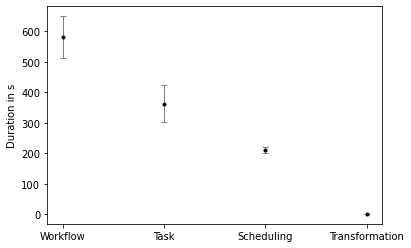

In [3]:
analysisWrapper("hadoop")

Performing Analysis for Case Study: mls
Fail to reject null hypothesis that data is normal for column Scheduling (p=0.222318>=0.012500)
Rejecting null hypothesis that data is normal for column Task (p=0.011190<0.012500)
Fail to reject null hypothesis that data is normal for column Workflow (p=0.414960>=0.012500)
Rejecting null hypothesis that data is normal for column Transformation (p=0.000865<0.012500)
Using Levene's test for homoscedacity of non-normal data.
Fail to reject null hypothesis that all variances are equal (p=0.139863>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.001817)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
Index(['meanrank', 'median', 'mad', 'ci_lower', 'ci_upper', 'effect_size',
       'magnitude'],
      dtype='object')


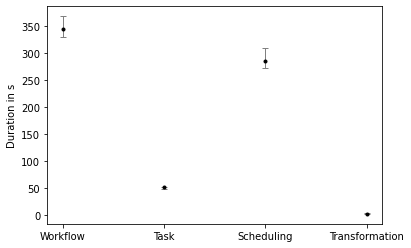

In [4]:
analysisWrapper("mls")

Performing Analysis for Case Study: shark/nonPar
Fail to reject null hypothesis that data is normal for column Scheduling (p=0.591210>=0.012500)
Fail to reject null hypothesis that data is normal for column Task (p=0.349819>=0.012500)
Fail to reject null hypothesis that data is normal for column Workflow (p=0.786203>=0.012500)
Fail to reject null hypothesis that data is normal for column Transformation (p=0.627874>=0.012500)
Using Bartlett's test for homoscedacity of normally distributed data
Rejecting null hypothesis that all variances are equal (p=0.000000<0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000440)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
Index(['meanrank', 'mean', 'std', 'ci_lower', 'ci_upper', 'effect_size',
       'magnitude'],
      dtype='object')


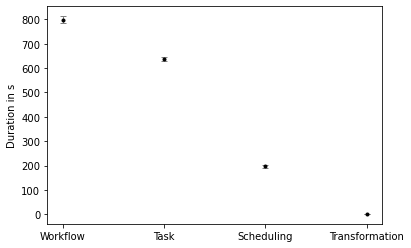

In [5]:
analysisWrapper("shark/nonPar")

Performing Analysis for Case Study: shark/Par
Fail to reject null hypothesis that data is normal for column Scheduling (p=0.279259>=0.012500)
Fail to reject null hypothesis that data is normal for column Task (p=0.264323>=0.012500)
Fail to reject null hypothesis that data is normal for column Workflow (p=0.751080>=0.012500)
Fail to reject null hypothesis that data is normal for column Transformation (p=0.475005>=0.012500)
Using Bartlett's test for homoscedacity of normally distributed data
Rejecting null hypothesis that all variances are equal (p=0.000266<0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.001817)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
Index(['meanrank', 'mean', 'std', 'ci_lower', 'ci_upper', 'effect_size',
       'magnitude'],
      dtype='object')


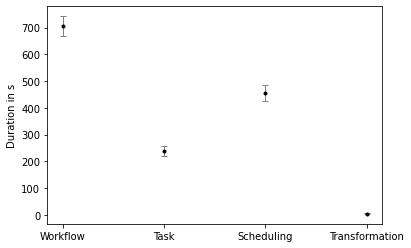

In [6]:
analysisWrapper("shark/Par")